# MLPy — Sesión 5: Optimizadores y Dinámica del Aprendizaje (PyTorch)

En esta sesión comparamos **SGD**, **Momentum**, **RMSProp** y **Adam** manteniendo constantes:

- el **mismo dataset**
- el **mismo modelo**
- el **mismo training loop**
- las **mismas métricas**

> La meta: observar **dinámica** (curvas) y **estabilidad**, no solo el resultado final.


In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

torch.manual_seed(0)


## 1) Dataset (clasificación 2D) y splits

Usamos el mismo estilo de dataset que en Sesión 4 para enfocarnos en los optimizadores.


In [2]:
# Dataset sintético: dos clases separadas en 2D
N = 800
x0 = torch.randn(N//2, 2) + torch.tensor([-2.0, 0.0])
x1 = torch.randn(N//2, 2) + torch.tensor([ 2.0, 0.0])

X = torch.cat([x0, x1], dim=0)
y = torch.cat([torch.zeros(N//2), torch.ones(N//2)]).long()

# Mezclar
perm = torch.randperm(N)
X, y = X[perm], y[perm]

# Split entrenamiento / validación
train_frac = 0.8
n_train = int(N * train_frac)
X_train, y_train = X[:n_train], y[:n_train]
X_val,   y_val   = X[n_train:], y[n_train:]

X_train.shape, X_val.shape


(torch.Size([640, 2]), torch.Size([160, 2]))

## 2) Modelo base y funciones comunes

Mantendremos la arquitectura fija para que el *único* cambio sea el optimizador.


In [3]:
def make_model(seed: int = 0) -> nn.Module:
    torch.manual_seed(seed)
    return nn.Sequential(
        nn.Linear(2, 16),
        nn.ReLU(),
        nn.Linear(16, 2)
    )

criterion = nn.CrossEntropyLoss()

def accuracy_from_logits(logits: torch.Tensor, y_true: torch.Tensor) -> float:
    preds = torch.argmax(logits, dim=1)
    return (preds == y_true).float().mean().item()


def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for xb, yb in loader:
        logits = model(xb)
        loss = criterion(logits, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, yb)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, total_acc, n_batches = 0.0, 0.0, 0

    for xb, yb in loader:
        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += loss.item()
        total_acc  += accuracy_from_logits(logits, yb)
        n_batches += 1

    return total_loss / n_batches, total_acc / n_batches


## 3) Fábrica de optimizadores

Usaremos configuraciones típicas, pero **sin afirmar que son universales**.

- Momentum: `momentum=0.9`
- RMSProp / Adam: suelen funcionar con `lr` más pequeño que SGD


In [4]:
def make_optimizer(name: str, model: nn.Module, lr: float):
    name = name.lower().strip()
    if name == "sgd":
        return torch.optim.SGD(model.parameters(), lr=lr)
    if name == "momentum":
        return torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if name == "rmsprop":
        return torch.optim.RMSprop(model.parameters(), lr=lr, alpha=0.99, eps=1e-8)
    if name == "adam":
        return torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
    raise ValueError(f"Optimizador desconocido: {name}")


## 4) Runner: mismo experimento, distinto optimizador

Registramos por época:

- `train_loss`, `val_loss`
- `train_acc`, `val_acc`


In [5]:
def run_experiment(opt_name: str, lr: float, epochs: int = 40, batch_size: int = 32, seed: int = 0):
    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val),     batch_size=batch_size, shuffle=False)

    model = make_model(seed=seed)
    optimizer = make_optimizer(opt_name, model, lr=lr)

    hist = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

    for _ in range(epochs):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        va_loss, va_acc = eval_one_epoch(model, val_loader, criterion)

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_acc"].append(tr_acc)
        hist["val_acc"].append(va_acc)

    return hist


## 5) Comparación rápida (curvas) con hiperparámetros razonables

Ejemplo típico:

- SGD: `lr=0.1`
- Momentum: `lr=0.1`
- RMSProp: `lr=0.01`
- Adam: `lr=0.01`

La meta es comparar **dinámica**, no “ganadores absolutos”.


In [6]:
experiments = {
    "SGD (lr=0.1)":       ("sgd", 0.1),
    "Momentum (lr=0.1)":  ("momentum", 0.1),
    "RMSProp (lr=0.01)":  ("rmsprop", 0.01),
    "Adam (lr=0.01)":     ("adam", 0.01),
}

results = {}
for label, (opt, lr) in experiments.items():
    results[label] = run_experiment(opt, lr=lr, epochs=40, batch_size=32, seed=0)

for label, hist in results.items():
    print(f"{label:18s} | val_loss={hist['val_loss'][-1]:.4f} | val_acc={hist['val_acc'][-1]:.3f}")


SGD (lr=0.1)       | val_loss=0.0510 | val_acc=0.988
Momentum (lr=0.1)  | val_loss=0.0566 | val_acc=0.975
RMSProp (lr=0.01)  | val_loss=0.0554 | val_acc=0.981
Adam (lr=0.01)     | val_loss=0.0543 | val_acc=0.981


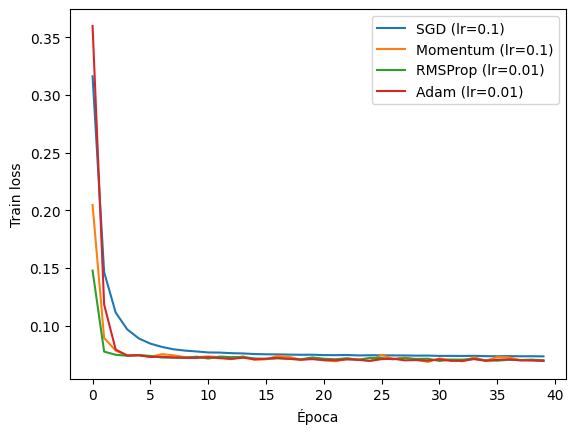

In [7]:
plt.figure()
for label, hist in results.items():
    plt.plot(hist["train_loss"], label=label)
plt.xlabel("Época")
plt.ylabel("Train loss")
plt.legend()
plt.show()


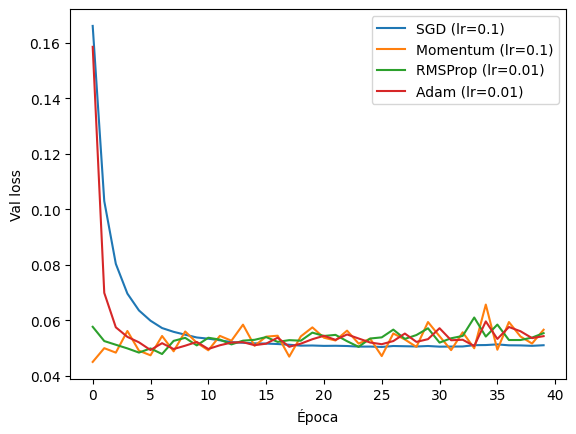

In [8]:
plt.figure()
for label, hist in results.items():
    plt.plot(hist["val_loss"], label=label)
plt.xlabel("Época")
plt.ylabel("Val loss")
plt.legend()
plt.show()


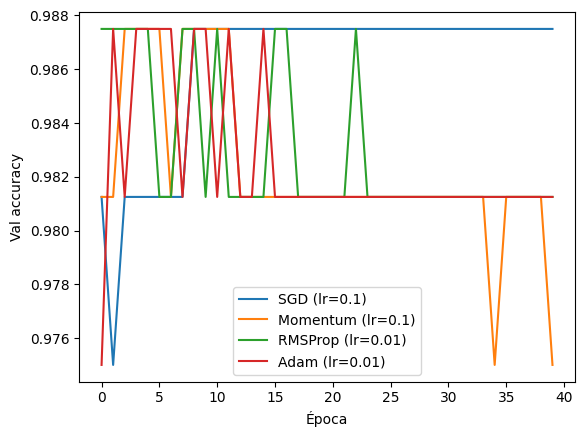

In [9]:
plt.figure()
for label, hist in results.items():
    plt.plot(hist["val_acc"], label=label)
plt.xlabel("Época")
plt.ylabel("Val accuracy")
plt.legend()
plt.show()


## 6) Sensibilidad al learning rate

Probamos varios `lr` para **SGD** y **Adam** para comparar sensibilidad.


In [10]:
def sweep_lrs(opt_name: str, lrs, epochs: int = 25, batch_size: int = 32):
    curves = {}
    for lr in lrs:
        hist = run_experiment(opt_name, lr=lr, epochs=epochs, batch_size=batch_size, seed=0)
        curves[lr] = hist["val_loss"]
    return curves

sgd_lrs  = [0.01, 0.05, 0.1, 0.2]
adam_lrs = [0.001, 0.003, 0.01, 0.03]

sgd_curves  = sweep_lrs("sgd",  sgd_lrs,  epochs=25)
adam_curves = sweep_lrs("adam", adam_lrs, epochs=25)

len(sgd_curves), len(adam_curves)


(4, 4)

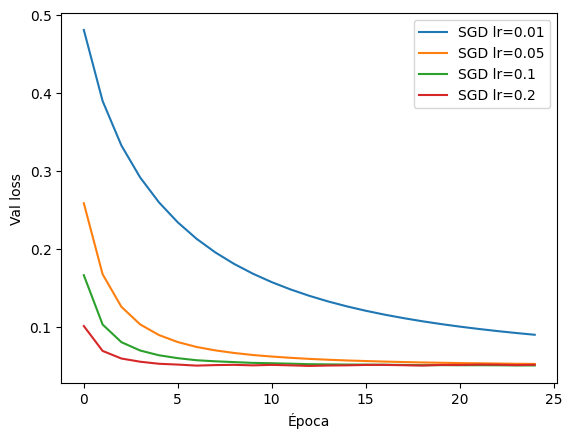

In [11]:
plt.figure()
for lr, curve in sgd_curves.items():
    plt.plot(curve, label=f"SGD lr={lr}")
plt.xlabel("Época")
plt.ylabel("Val loss")
plt.legend()
plt.show()


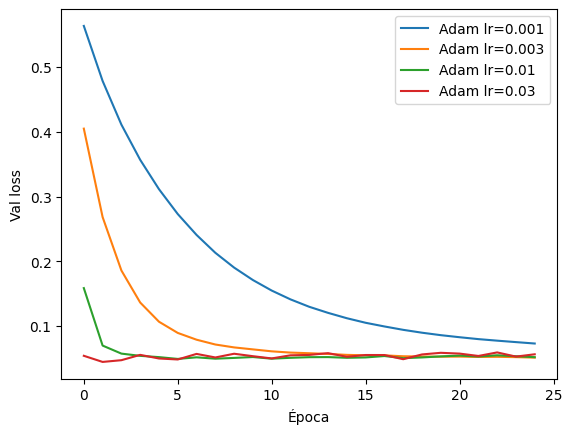

In [12]:
plt.figure()
for lr, curve in adam_curves.items():
    plt.plot(curve, label=f"Adam lr={lr}")
plt.xlabel("Época")
plt.ylabel("Val loss")
plt.legend()
plt.show()


## 7) Mini-experimento geométrico: valle alargado (intuición)

Función cuadrática mal condicionada:

\[ L(x, y) = a x^2 + b y^2 \quad (a \gg b) \]

Comparamos trayectorias con paso fijo vs Momentum (simulación didáctica).


In [13]:
def quad_grad(xy, a=50.0, b=1.0):
    x, y = float(xy[0]), float(xy[1])
    return torch.tensor([2*a*x, 2*b*y], dtype=torch.float32)

def gd_path(lr=0.02, steps=60, a=50.0, b=1.0, momentum=0.0):
    xy = torch.tensor([2.0, 2.0], dtype=torch.float32)
    v = torch.zeros_like(xy)
    path = [xy.clone()]

    for _ in range(steps):
        g = quad_grad(xy, a=a, b=b)
        if momentum > 0.0:
            v = momentum * v + g
            xy = xy - lr * v
        else:
            xy = xy - lr * g
        path.append(xy.clone())
    return torch.stack(path)

path_gd  = gd_path(lr=0.02, steps=60, a=50.0, b=1.0, momentum=0.0)
path_mom = gd_path(lr=0.02, steps=60, a=50.0, b=1.0, momentum=0.9)

path_gd.shape


torch.Size([61, 2])

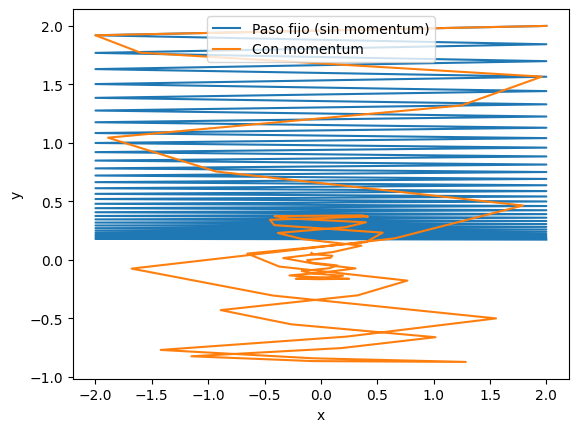

In [14]:
plt.figure()
plt.plot(path_gd[:,0].numpy(),  path_gd[:,1].numpy(),  label="Paso fijo (sin momentum)")
plt.plot(path_mom[:,0].numpy(), path_mom[:,1].numpy(), label="Con momentum")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 8) Preguntas de cierre (para discusión)

1. ¿Qué optimizador mostró curvas más estables? ¿por qué?

2. ¿Cuál fue más sensible al learning rate: SGD o Adam?

3. ¿Puedes identificar convergencia rápida pero poca mejora en validación?

4. En el valle alargado, ¿qué cambió con Momentum: dirección, tamaño de paso, o ambos?

5. ¿Qué criterio usarías para elegir optimizador en un proyecto real?

